**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Naive Bayes Classifier for mixed data

Implementation available [here](https://github.com/remykarem/mixed-naive-bayes).

We import the libraries and define constants and settings of the notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.preprocessing import LabelEncoder
from mixed_naive_bayes import MixedNB
from time import time
from classification_utils import *

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RANDOM_STATE = 42
RESULTS_DIR = '../data/classification_results'
clf_name = 'NaiveBayesMixedClassifier'

We load the data:

In [2]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use:

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day', 'day_of_week', 'month', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 31


We define a list of the categorical features:

In [4]:
categorical_features = [
    'day', 'day_of_week', 'month', 'year',
    'democrat', 'gun_law_rank',
    'aggression', 'accidental', 'defensive', 'suicide',
    'road', 'house', 'school', 'business',
    'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction'
]

# label encoding of categorical features in the training set
indicators_train_cat_df = indicators_train_df[categorical_features]
indicators_train_df = indicators_train_df.drop(columns=categorical_features)
indicators_train_cat_df = indicators_train_cat_df.apply(LabelEncoder().fit_transform)
indicators_train_df = pd.concat([indicators_train_df, indicators_train_cat_df], axis=1)
# label encoding of categorical features in the test set
indicators_test_cat_df = indicators_test_df[categorical_features]
indicators_test_df = indicators_test_df.drop(columns=categorical_features)
indicators_test_cat_df = indicators_test_cat_df.apply(LabelEncoder().fit_transform)
indicators_test_df = pd.concat([indicators_test_df, indicators_test_cat_df], axis=1)

categorical_features_pos = np.arange(len(indicators_train_df.columns) - len(categorical_features), len(indicators_train_df.columns))

We fit and test the model:

In [5]:
nb = MixedNB(categorical_features=categorical_features_pos)

# fit the model on all the training data
fit_start = time()
nb.fit(indicators_train_df, true_labels_train)
fit_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_train = nb.predict(indicators_train_df)
train_score_time = time()-train_score_start
pred_probas_train = nb.predict_proba(indicators_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_test = nb.predict(indicators_test_df)
test_score_time = time()-test_score_start
pred_probas_test = nb.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=nb, file=file)
file.close()

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.categorical_features == 'all':


We display traning and test scores:

In [6]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=nb,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NaiveBayesMixedClassifier,0.749308,0.877079,0.808174,0.590752,0.376823,0.460138,0.67003,0.626951,0.634156,0.698549,0.71693,0.696756,0.71693,0.735621,0.137668,0.040521,"MixedNB(alpha=0.5, var_smoothing=1e-09)"


In [7]:
test_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=nb,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)
test_scores

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NaiveBayesMixedClassifier,0.749081,0.879103,0.808901,0.593321,0.374601,0.459249,0.671201,0.626852,0.634075,0.699219,0.7176,0.696969,0.7176,0.733935,0.137668,0.021629,"MixedNB(alpha=0.5, var_smoothing=1e-09)"


We load and prepare randomly oversampled data:

In [8]:
indicators_over_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_over_train_df = indicators_over_train_df[features_for_clf]
true_labels_over_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

# label encoding of categorical features
indicators_over_train_cat_df = indicators_over_train_df[categorical_features]
indicators_over_train_df = indicators_over_train_df.drop(columns=categorical_features)
indicators_over_train_cat_df = indicators_over_train_cat_df.apply(LabelEncoder().fit_transform)
indicators_over_train_df = pd.concat([indicators_over_train_df, indicators_over_train_cat_df], axis=1)

We fit and test the best model on the oversampled dataset:

In [9]:
# fit the model on all the training data
nb_over = MixedNB(categorical_features=categorical_features_pos)
fit_start = time()
nb_over.fit(indicators_over_train_df, true_labels_over_train)
fit_over_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_over_train = nb_over.predict(indicators_over_train_df)
train_score_over_time = time()-train_score_start
pred_probas_over_train = nb_over.predict_proba(indicators_over_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_over_test = nb_over.predict(indicators_test_df)
test_score_over_time = time()-test_score_start
pred_probas_over_test = nb_over.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_over_test, 'probs': pred_probas_over_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversample_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversample.pkl', 'wb')
pickle.dump(obj=nb_over, file=file)
file.close()

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.categorical_features == 'all':


We load and prepare SMOTE oversampled data:

In [10]:
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

# label encoding of categorical features
indicators_smote_train_cat_df = indicators_smote_train_df[categorical_features]
indicators_smote_train_df = indicators_smote_train_df.drop(columns=categorical_features)
indicators_smote_train_cat_df = indicators_smote_train_cat_df.apply(LabelEncoder().fit_transform)
indicators_smote_train_df = pd.concat([indicators_smote_train_df, indicators_smote_train_cat_df], axis=1)

We fit and test the best model on the SMOTE oversampled dataset:

In [11]:
# fit the model on all the training data
nb_smote = MixedNB(categorical_features=categorical_features_pos)
fit_start = time()
nb_smote.fit(indicators_smote_train_df, true_labels_smote_train)
fit_smote_time = time()-fit_start

# get the predictions on the training data
train_score_start = time()
pred_labels_smote_train = nb_smote.predict(indicators_smote_train_df)
train_score_smote_time = time()-train_score_start
pred_probas_smote_train = nb_smote.predict_proba(indicators_smote_train_df)

# get the predictions on the test data
test_score_start = time()
pred_labels_smote_test = nb_smote.predict(indicators_test_df)
test_score_smote_time = time()-test_score_start
pred_probas_smote_test = nb_smote.predict_proba(indicators_test_df)

# save the predictions
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=nb_smote, file=file)
file.close()

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.categorical_features == 'all':


We compare the performance of the best model on the three datasets:

In [12]:
test_over_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_over_test,
    train_time=fit_over_time,
    score_time=test_score_over_time,
    params=None,
    prob_pred=pred_probas_over_test,
    clf_name=clf_name+' over',
    path=f'{RESULTS_DIR}/{clf_name}_over_test_scores.csv'
)

test_smote_scores = compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_smote_time,
    score_time=test_score_smote_time,
    params=None,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name+' SMOTE',
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

pd.concat([test_scores, test_over_scores, test_smote_scores])

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NaiveBayesMixedClassifier,0.749081,0.879103,0.808901,0.593321,0.374601,0.459249,0.671201,0.626852,0.634075,0.699219,0.717600,0.696969,0.717600,0.733935,0.137668,0.021629,"MixedNB(alpha=0.5, var_smoothing=1e-09)"
NaiveBayesMixedClassifier over,0.777742,0.799084,0.788268,0.546887,0.515014,0.530472,0.662314,0.657049,0.659370,0.703840,0.708147,0.705742,0.708147,0.733981,0.150794,0.016949,None
NaiveBayesMixedClassifier SMOTE,0.780559,0.797413,0.788896,0.549066,0.523887,0.536181,0.664813,0.660650,0.662539,0.706453,0.709851,0.707996,0.709851,0.734527,0.146637,0.018939,None


We display confusion matrices:

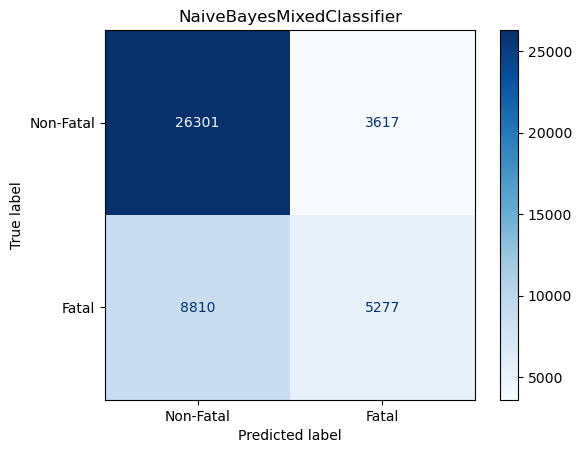

In [13]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    title=clf_name
)

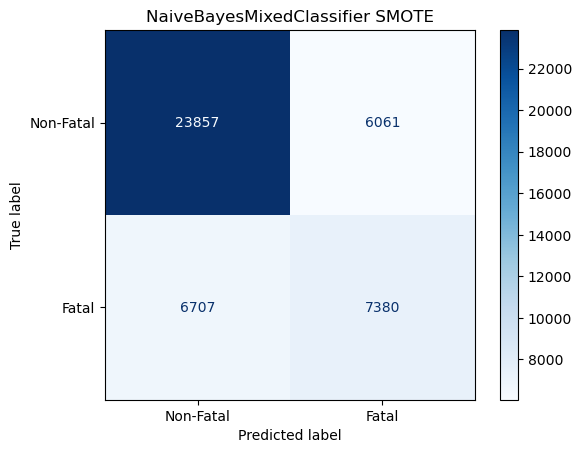

In [14]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name + ' SMOTE'
)

We plot incidents (actual class and predicted class) in different feature spaces:

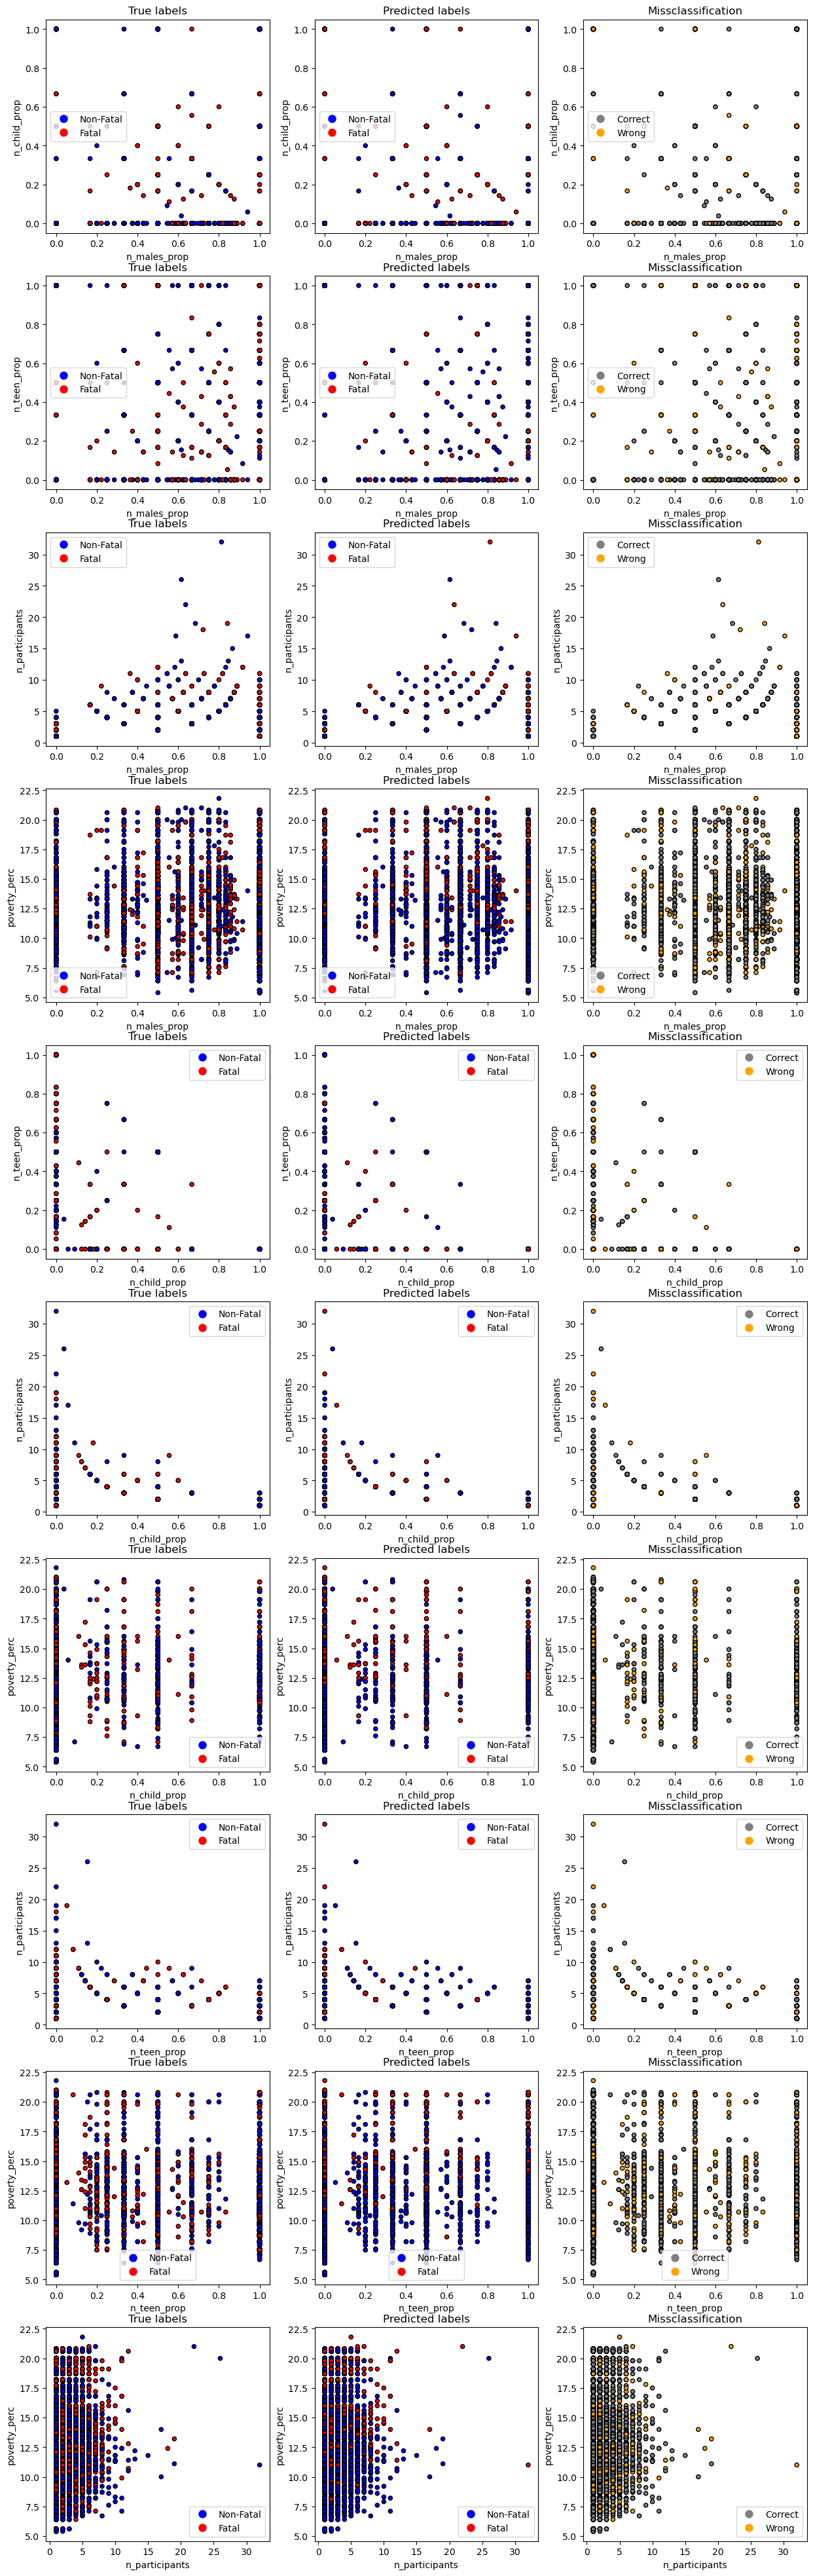

In [15]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['n_males_prop', 'n_child_prop', 'n_teen_prop', 'n_participants', 'poverty_perc'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_test,
    figsize=(15, 50)
)

We plot the ROC curve:

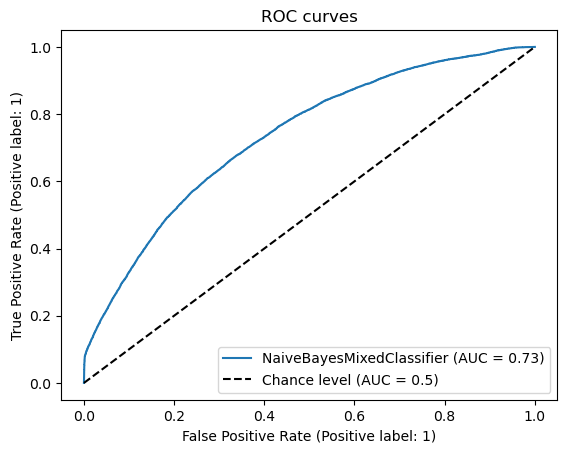

In [16]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_test[:,1]], names=[clf_name])

We plot the learning curve:

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform 

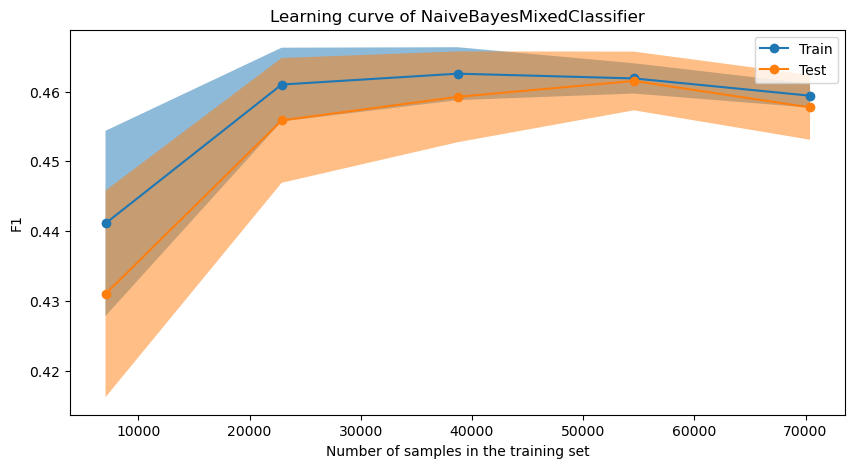

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=nb,
    classifier_name=clf_name,
    train_set=indicators_train_df,
    labels=true_labels_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

We plot the distribution of the features for misclassified incidents:

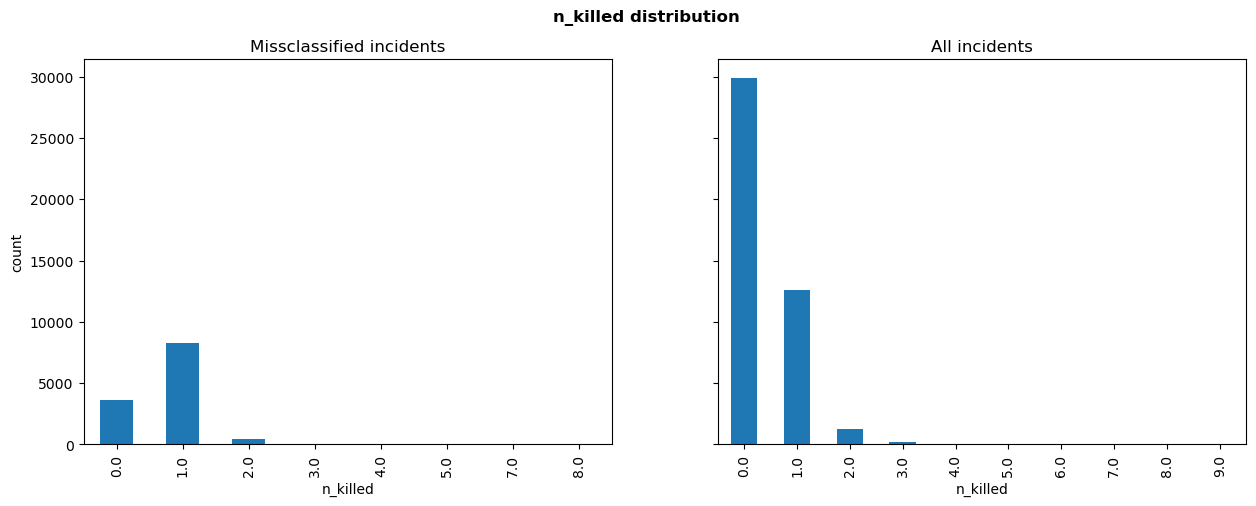

In [18]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

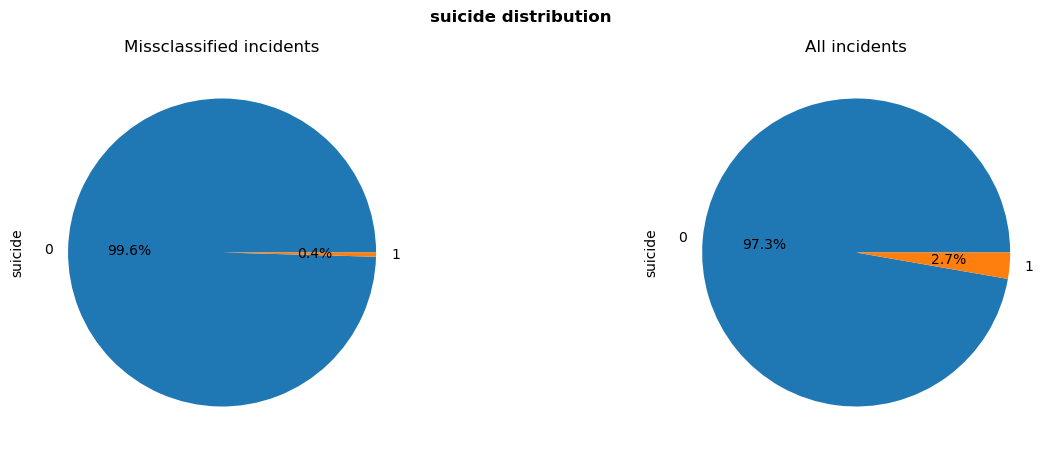

In [19]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

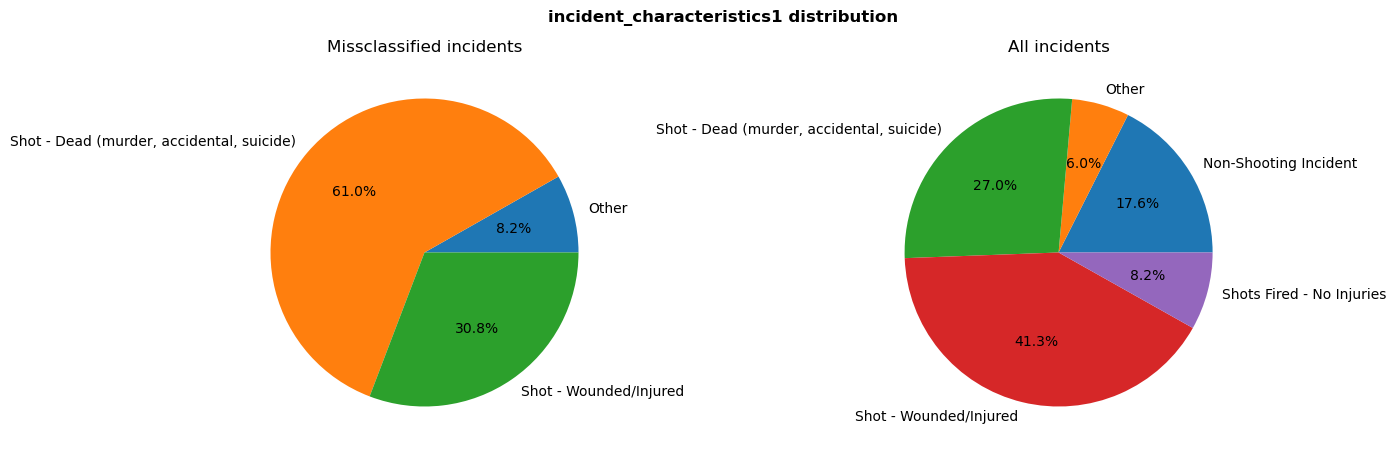

In [20]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics1',
    'pie',
    title='incident_characteristics1 distribution'
)

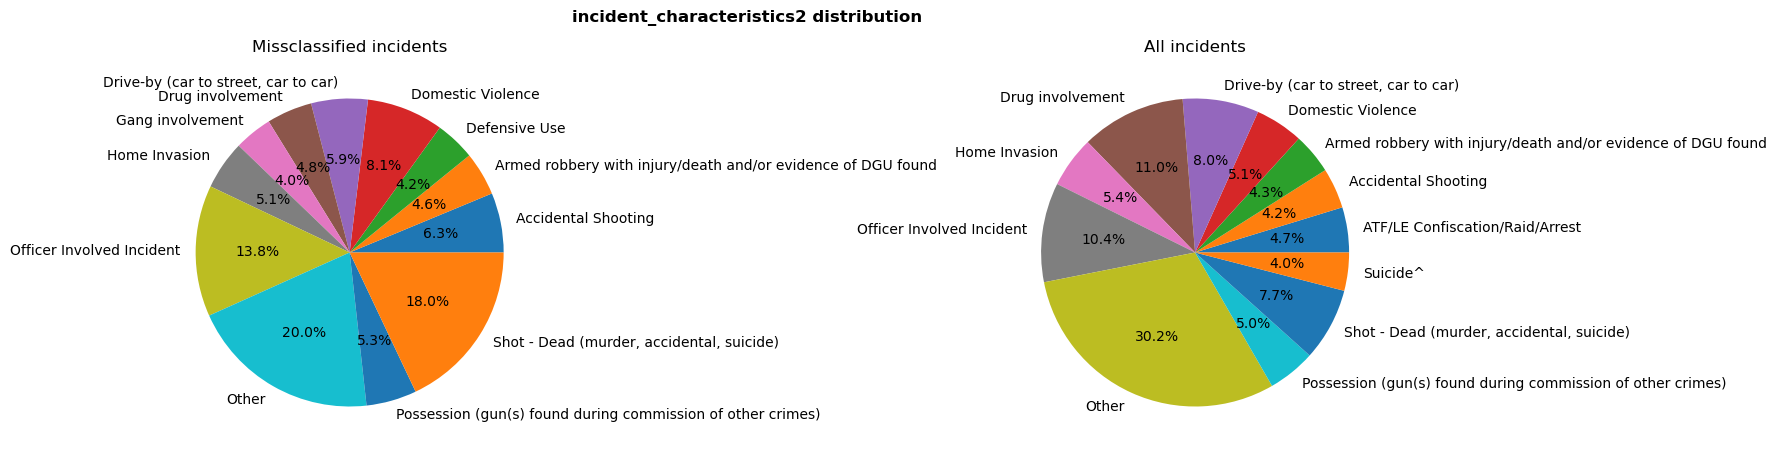

In [21]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'incident_characteristics2',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='incident_characteristics2 distribution'
)

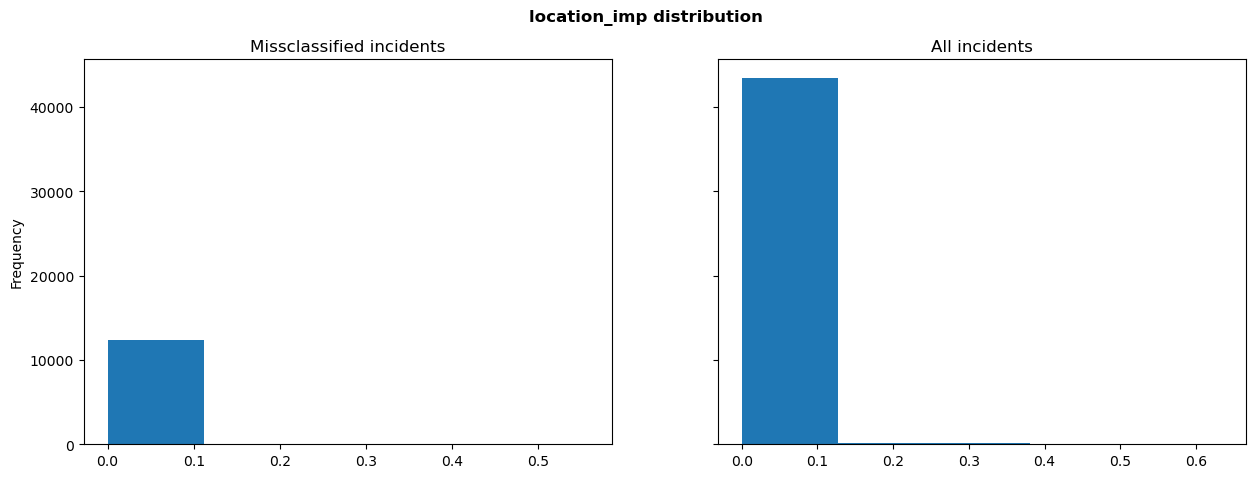

In [22]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)